# README
このファイルはgoogle colab上で使用できます．上から順にセルを実行していくと問題なく動くと思います．  
動かすときはtxtを読み込むディレクトリなどに注意してください．  
(うまくいかない的なことを書いてるところは，実行自体は問題なくできますが，所望の結果が返ってこないです．)  
  
【やったこと】  
- 課題1(adrianから自分(cody)までたどり着けるか？)に関して，BFSとDFSの実装による実行時間比較  
- 課題1(発展ver1)として，自分(cody)から何人の人にたどり着けるか，何人の人から自分(cody)にたどり着けるか調査  
 -> 改良版のところで，探索順序による結果反映漏れのバグが直せない，やっぱりある程度の重複探索はしょうがないのかな？  
 -> うまくいったらアップデートします．(現時点では解決策を思いついていない．)
- 課題1(発展ver2)として，adrianから自分までの最短経路の把握  
- 課題1(発展ver3)として，PageRankにより重要そうな人を抽出  
 -> wikipediaのデータがでかすぎて無理だったので再挑戦！したけど，結果が正しいかの判断ができない笑
- 課題1(息抜き脱線編)として，node2vec + k-meansを使ってクラスタ把握とハブとなっている度合いを推定  
 -> やっぱりハイパラのチューニングがびみょい．目視でのうまくいっているかの判断が難しい．

## 必要な準備

In [0]:
from google.colab import auth, drive, files, output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/STEP2020")

## SNS解析 - データの準備


In [0]:
#nicknamesの読み込み
f1 = open('txt/sns/nicknames.txt')
nicknames = f1.read()
f1.close()
nicknames = nicknames.split("\n")
#何故かreとsplit('\\')がうまくいかなかったな..
for i in range(len(nicknames)):
    if i < 10:
        nicknames[i] = nicknames[i][2:]
    else:
        nicknames[i] = nicknames[i][3:]
#nicknames #確認用

In [0]:
#名前から番号を検索できるようにしておく．
from collections import defaultdict
name2num = defaultdict(int)
for i in range(len(nicknames)):
    name2num[nicknames[i]] = i
#name2num #確認用

In [0]:
#linksの読み込み
f1 = open('txt/sns/links.txt')
links = f1.read()
f1.close()
links = links.split("\n")
links = tuple([tuple(map(int, links[i].split('\t'))) for i in range(len(links))])
#links #確認用

In [0]:
#隣接リスト作成
direct_neighbors = [[] for i in range(len(nicknames))]
for link in links:
    direct_neighbors[link[0]].append(link[1])
#direct_neighbors #確認用

## 課題1 - adrianからcodyまでたどり着けるか？
結論を先にまとめると，実行時間は今回はBFSの方が少し(約40倍，4/1000秒)速かった．おそらくグラフの形による？と思われる．  
BFS: 0.00016641616821289062  
DFS: 0.004436969757080078

### BFS編

In [0]:
import time
from collections import deque

def bfs(direct_neighbors, visited, start, goal):
    q = deque()
    q.extend(direct_neighbors[start])
    visited[start] = True
    while len(q) > 0:
        node_num = q.popleft()
        visited[node_num] = True
        for next_node in direct_neighbors[node_num]:
            if next_node == goal:
                return True
            elif (visited[next_node] == False) and (next_node not in q):
                q.append(next_node)
    return False

start = name2num['adrian']
goal = name2num['cody']
visited = [False for i in range(len(nicknames))]

bfs_time_start = time.time()
if bfs(direct_neighbors, visited, start, goal):
    print('adrianからcodyまでたどり着ける')
else:
    print('adrianからcodyまでたどり着けない')
bfs_time_finish = time.time()

print('実行時間：', bfs_time_finish - bfs_time_start)

adrianからcodyまでたどり着ける
実行時間： 0.00016641616821289062


### DFS編

In [0]:
import time
from collections import deque

def dfs(direct_neighbors, visited, start, goal):
    for next_node in direct_neighbors[start]:
        if next_node == goal:
            return True
        elif visited[next_node] == False:
            visited[next_node] = True
            if dfs(direct_neighbors, visited, next_node, goal):
                return True
    return False

start = name2num['adrian']
goal = name2num['cody']
visited = [False for i in range(len(nicknames))]

dfs_time_start = time.time()
if dfs(direct_neighbors, visited, start, goal):
    print('adrianからcodyまでたどり着ける')
else:
    print('adrianからcodyまでたどり着けない')
dfs_time_finish = time.time()

print('実行時間：', dfs_time_finish - dfs_time_start)

adrianからcodyまでたどり着ける
実行時間： 0.004436969757080078


## 課題1(発展ver1) - codyと繋がっているのは？
### codyから探索を始める編
実装のポイント：探索の終了判定はqueueの中のnodeがなくなった時として，このノードに到達したら終了のようにしないようにする．それにより，for文でgoalを指定して探索するより計算量が減らせる．



In [0]:
import time
from collections import deque

def bfs(direct_neighbors, visited, start):
    q = deque()
    q.extend(direct_neighbors[start])
    visited[start] = True
    while len(q) > 0:
        node_num = q.popleft()
        visited[node_num] = True
        for next_node in direct_neighbors[node_num]:
            if (visited[next_node] == False) and (next_node not in q):
                q.append(next_node)

start = name2num['cody']
visited = [False for i in range(len(nicknames))]
not_yet = []

bfs_time_start = time.time()
bfs(direct_neighbors, visited, start)
print('codyから到達できる人数：', sum(visited))
for i in range(len(visited)):
    if visited[i] == False:
        not_yet.append(nicknames[i])
print('codyからたどれない人：', not_yet)
bfs_time_finish = time.time()

print('実行時間：', bfs_time_finish - bfs_time_start)

codyから到達できる人数： 51
codyからたどれない人： ['betty', 'carolyn', 'lawrence']
実行時間： 0.00044536590576171875


### codyまで探索してみる編
実装のポイント：startはfor文で回すのだが，一度探索したところともう一度探索すると効率が悪いので，reachedにぶつかったら探索を終了するようにして計算量を減らした．ただ，頑張ればもう少し計算量を減らせそう(まだダブルサーチを減らせそう)ということに気づいたので，実装がうまくいったら更新する可能性あり．  
-> 改善ver.をこれの後に実装したが，現状うまくいっていない．

In [0]:
import time
from collections import deque

def bfs(direct_neighbors, visited, reached, start, goal):
    q = deque()
    q.extend(direct_neighbors[start])
    visited[start] = True
    while len(q) > 0:
        node_num = q.popleft()
        visited[node_num] = True
        for next_node in direct_neighbors[node_num]:
            if (next_node == goal) or (reached[next_node] == True):
                return True
            elif (visited[next_node] == False) and (next_node not in q):
                q.append(next_node)
    return False

goal = name2num['cody']
reached = [False for i in range(len(nicknames))]
cannot_reach = []

bfs_time_start = time.time()
for i in range(len(reached)):
    visited = [False for i in range(len(nicknames))]
    if bfs(direct_neighbors, visited, reached, i, goal):
        reached[i] = True
print('codyまで到達できる人数：', sum(reached))
for i in range(len(reached)):
    if reached[i] == False:
        cannot_reach.append(nicknames[i])
print('codyまでたどれない人：', cannot_reach)
bfs_time_finish = time.time()

print('実行時間：', bfs_time_finish - bfs_time_start)

codyまで到達できる人数： 51
codyまでたどれない人： ['betty', 'carolyn', 'lawrence']
実行時間： 0.00054931640625


### 再帰使って改良してみる編
再帰使った方が探索にダブりがなくて良さげと思ったので，dfsに方針変更．  
-> 'jerry'はたどり着けるはずなんだけどなんでだ？   
-> もしかして，探索の順番かな..解決策が浮かばない．

In [0]:
import time
from collections import deque

def dfs(direct_neighbors, visited, start):
    visited[start][0] = True
    for next_node in direct_neighbors[start]:
        #探索済でたどり着けた場合と，ゴールに到達した場合
        if visited[next_node][1] == True:
            visited[start][1] = True
            return True
        #まだ探索していない場合は再帰
        elif visited[next_node][0] == False:
            if dfs(direct_neighbors, visited, next_node):
                visited[start][1] = True
                return True
    return False

goal = name2num['cody']
visited = [[False, False] for i in range(len(nicknames))] #ひとつ目に既に探索したか，二つ目に探索の結果たどり着けたかを入れておく．
visited[goal] = [True, True]
cannot_reach = []

dfs_time_start = time.time()
for i in range(len(visited)):
    if (visited[i][0] == False):
        result = dfs(direct_neighbors, visited, i)
print('codyまで到達できる人数：', sum([visited[i][1] for i in range(len(visited))]))
for i in range(len(visited)):
    if visited[i][1] == False:
        cannot_reach.append(nicknames[i])
print('codyからたどれない人：', cannot_reach)
dfs_time_finish = time.time()
print('実行時間：', dfs_time_finish - dfs_time_start)

codyまで到達できる人数： 50
codyからたどれない人： ['betty', 'carolyn', 'jerry', 'lawrence']
実行時間： 0.00046443939208984375


## 課題1(発展ver2) - adrian->codyの最短ルートは？
実装のポイント：cacheのときのように，自分のひとつ前のノードを覚えておいて，後ろから逆順にたどればよい．  
注意すべき点は，次のノードは複数存在するかもしれないが，自分に至るまでの最小ルートは選べることである．  
なので，逆順からたどっている．


In [0]:
import time
from collections import deque

def bfs(direct_neighbors, visited, start, goal):
    q = deque()
    for next_node in direct_neighbors[start]:
        q.append(next_node)
        prev_nodes[next_node] = start
    visited[start] = True
    while len(q) > 0:
        node_num = q.popleft()
        visited[node_num] = True
        for next_node in direct_neighbors[node_num]:
            if next_node == goal:
                prev_nodes[next_node] = node_num
                return True
            elif (visited[next_node] == False) and (next_node not in q):
                q.append(next_node)
                prev_nodes[next_node] = node_num
    return False

start = name2num['adrian']
goal = name2num['cody']
visited = [False for i in range(len(nicknames))]
prev_nodes = [None for i in range(len(nicknames))]
prev_nodes[start] = 'start'

bfs_time_start = time.time()
if bfs(direct_neighbors, visited, start, goal):
    print('adrianからcodyまでたどり着ける')
else:
    print('adrianからcodyまでたどり着けない')
pathway = [nicknames[goal]]
visiting = prev_nodes[goal]
while True:
    pathway.append(nicknames[visiting])
    if prev_nodes[visiting] == 'start':
        break
    visiting = prev_nodes[visiting]
print('adrianからcodyまでつながる最小人数のときの人物は，', list(reversed(pathway)))
bfs_time_finish = time.time()

print('実行時間：', bfs_time_finish - bfs_time_start)

adrianからcodyまでたどり着ける
adrianからcodyまでつながる最小人数のときの人物は， ['adrian', 'emma', 'cody']
実行時間： 0.0008184909820556641


## 課題1(発展ver3) - PageRankで重要度が高い人を抽出
wikipediaデータがでかすぎてできなかったので，今度こそ！

In [0]:
#リンク行列の作成
import numpy as np
size = len(nicknames)
p_matrix = np.zeros((size, size))
e_matrix = np.ones((size, size))

In [0]:
for i in range(len(links)):
    p_matrix[links[i][0]][links[i][1]] += 1
for i in range(size):
    if sum(p_matrix[i]) != 0:
        p_matrix[i] = p_matrix[i]/sum(p_matrix[i])

In [0]:
google_matrix = 0.85 * p_matrix + 0.15 * (1/size) * e_matrix

In [0]:
import numpy.linalg as LA
PageRank = 100 * np.ones((size, size))
#たぶんこのくらいの要素数であれば20回で十分収束する．
for i in range(20):
    PageRank = PageRank * google_matrix
w,v = LA.eig(PageRank)

In [0]:
w_index = list(reversed(sorted([[w[i], i] for i in range(size)])))

In [0]:
#ハブになっていそうな人を10人出してみる
#出せたけど本当にこの人たちが重要度高いのかが分からない..笑
for i in range(10):
    print(nicknames[w_index[i][1]], w_index[i][0])

aaron (7.47663167788893e-05+0j)
alan (3.4977929664413175e-14+0j)
carolyn (8.614898244221482e-17+0j)
betty (8.263455501307075e-17+1.1320666357307615e-16j)
brenda (8.263455501307075e-17-1.1320666357307615e-16j)
cheryl (7.51116268218034e-18+0j)
cody (4.302601666770589e-18+0j)
danielle (1.673036590419404e-18+0j)
darryl (9.816663849226857e-19+0j)
emma (4.2312741164062006e-20+0j)


## 課題1(息抜き脱線編) - node2vec + k-meansで遊んでみる
改良編のバグの修正がうまくいかなくて悲しいので一旦アルゴリズムは忘れてライブラリで遊ぶ．  
node2vecの概要とハイパラについては，[論文](https://arxiv.org/abs/1607.00653)または[解説記事](https://qiita.com/nishiba/items/6c8cc110a64cac48a0fc)が分かりやすい． [[公式GitHub]](https://github.com/aditya-grover/node2vec)  
直観的には，ハイパラのp,qはランダムウォーク的探索の温度バランスのようなイメージ．

### いろいろと準備する編

In [0]:
!pip install node2vec

In [0]:
from sklearn.cluster import KMeans
import numpy as np
import node2vec
import networkx as nx
import pandas as pd
from scipy.cluster.hierarchy import linkage,dendrogram
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
link_weights = [(links[i][0], links[i][1], 1) for i in range(len(links))]
#link_weights #確認用

In [0]:
Graph = nx.DiGraph()  # 有向グラフ (Directed Graph)
Graph.add_weighted_edges_from(link_weights)

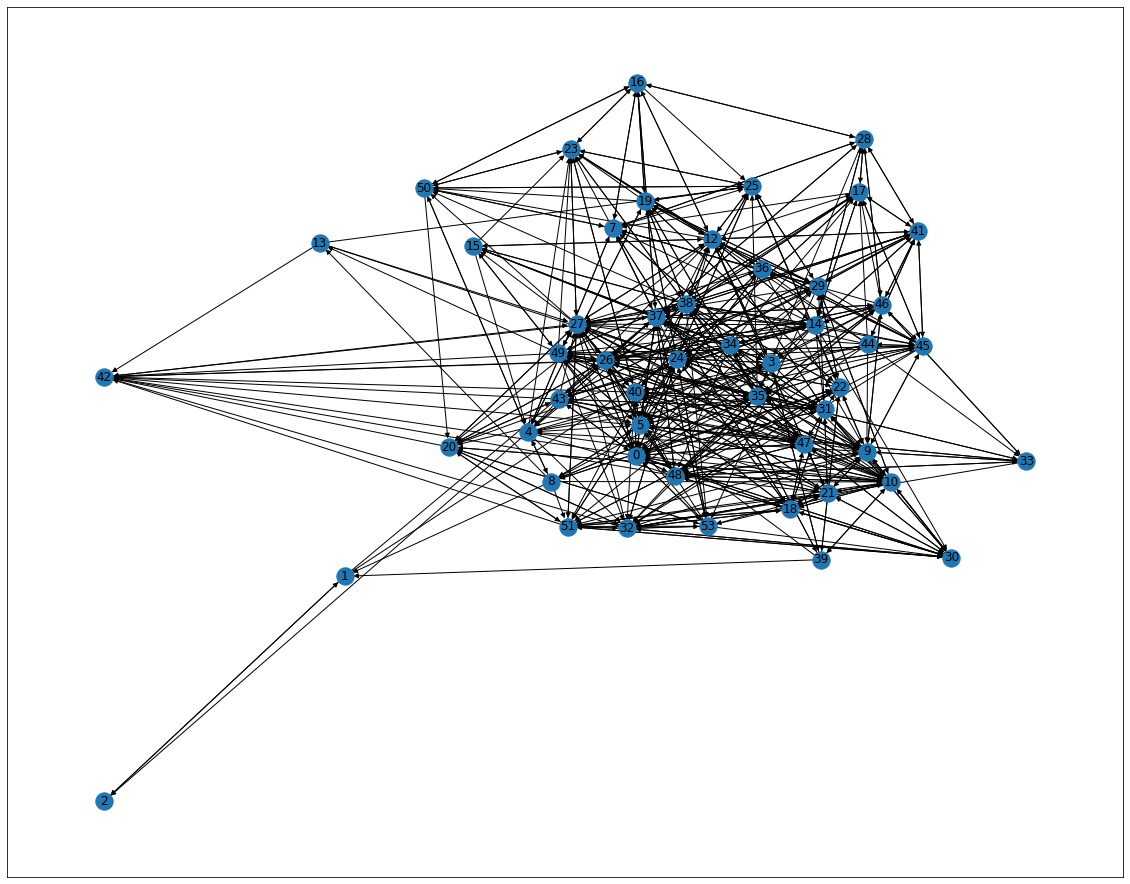

In [0]:
plt.figure(figsize=(20, 16))
nx.draw_networkx(Graph)
plt.show()

### クラスタ見つけてみる編

In [0]:
#パラメータチューニング難しい..論文通り+何通りかやってみたけど，ほんとにクラスタ把握できてるのかな？？
Preparation1 = node2vec.Node2Vec(Graph,p=1,q=0.5, dimensions=64, walk_length=10, num_walks=10, workers=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 29.29it/s]


In [0]:
model1 = Preparation1.fit(window=10, min_count=1, batch_words=4)

In [0]:
vectors1 = []
#なぜかベクトル化されていないインデックスがある..?
for i in range(len(nicknames)):
    try:
        vectors1.append(model1.wv[str(i)])
    except:
        vectors1.append(np.nan)

In [0]:
df1 = pd.DataFrame()
df1['vector'] = vectors1

In [0]:
df1 = df1.dropna(how='any', axis=0)

In [0]:
X1 = list(df1['vector'])
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(X1)
result1 = kmeans1.labels_
df1['cluster'] = result1

In [0]:
df1.head()

,vector,cluster
0,"[-0.06427817, 0.03984791, 0.06373487, 0.077744...",1
1,"[-0.07363581, 0.03415601, 0.052878886, 0.07445...",1
2,"[-0.06715544, 0.04487821, 0.06794245, 0.068407...",1
3,"[-0.08391296, 0.046483155, 0.06275203, 0.08854...",2
4,"[-0.08610398, 0.048440635, 0.07817503, 0.08566...",2


In [0]:
#保存
df1.to_csv('csv/node2vec_group.csv')

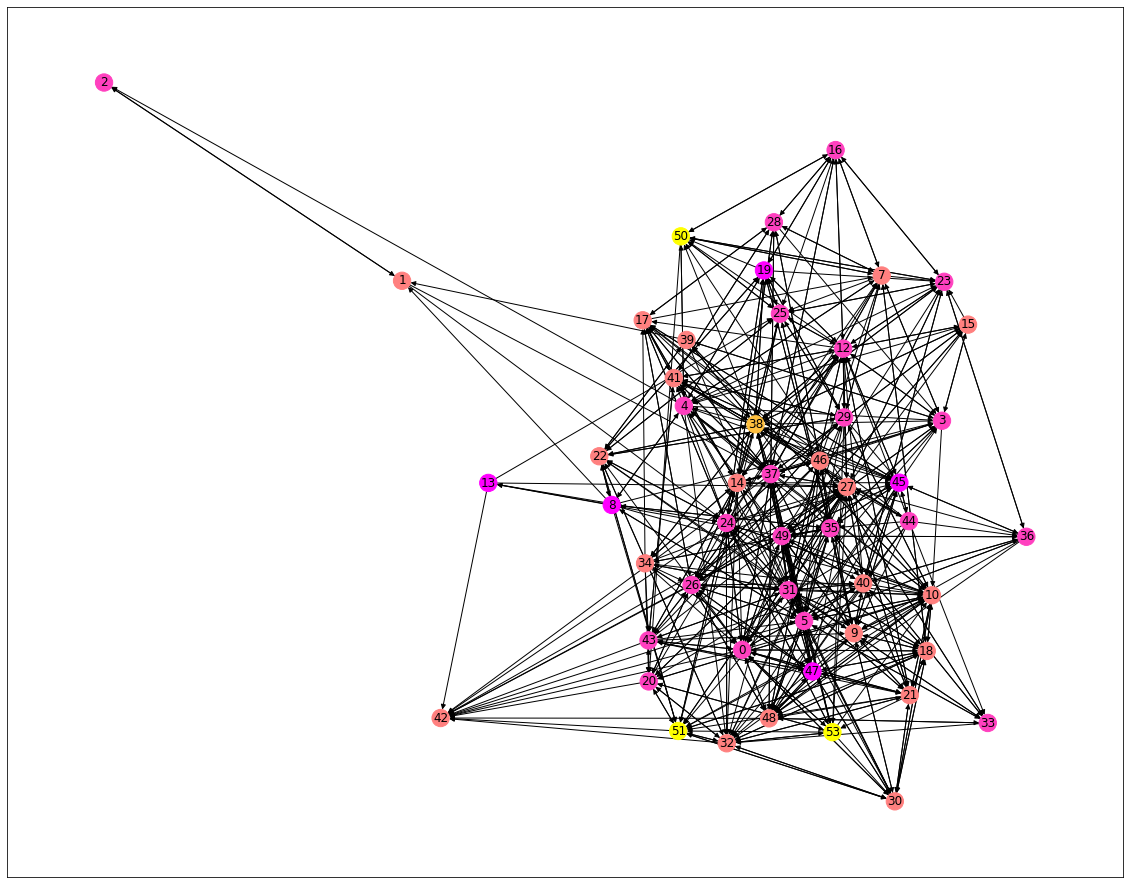

In [0]:
plt.figure(figsize=(20, 16))
nx.draw_networkx(Graph, node_color=list(df1['cluster']), cmap=plt.cm.spring)
plt.show()

### ハブになってる人発見する編

In [0]:
#パラメータチューニング大丈夫かな？ #とりあえず論文と同じ感じでやる
Preparation2 = node2vec.Node2Vec(Graph,p=1,q=2, dimensions=64, walk_length=10, num_walks=10, workers=1)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 49.97it/s]


In [0]:
model2 = Preparation2.fit(window=10, min_count=1, batch_words=4)

In [0]:
vectors2 = []
#なぜかベクトル化されていないインデックスがある..?
for i in range(len(nicknames)):
    try:
        vectors2.append(model1.wv[str(i)])
    except:
        vectors2.append(np.nan)

In [0]:
df2 = pd.DataFrame()
df2['vector'] = vectors2

In [0]:
df2 = df2.dropna(how='any', axis=0)

In [0]:
X2 = list(df2['vector'])
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(X2)
result2 = kmeans2.labels_
df2['cluster'] = result2

In [0]:
df2.head()

,vector,cluster
0,"[-0.062534995, 0.031500265, 0.06038772, 0.0906...",2
1,"[-0.06641251, 0.023743471, 0.044930197, 0.0806...",0
2,"[-0.052880734, 0.031102305, 0.0531557, 0.06563...",0
3,"[-0.09247062, 0.041354652, 0.06918469, 0.11758...",1
4,"[-0.07798886, 0.035333287, 0.06969445, 0.09480...",1


In [0]:
#とりあえず保存
df2.to_csv('csv/node2vec_influencer.csv')

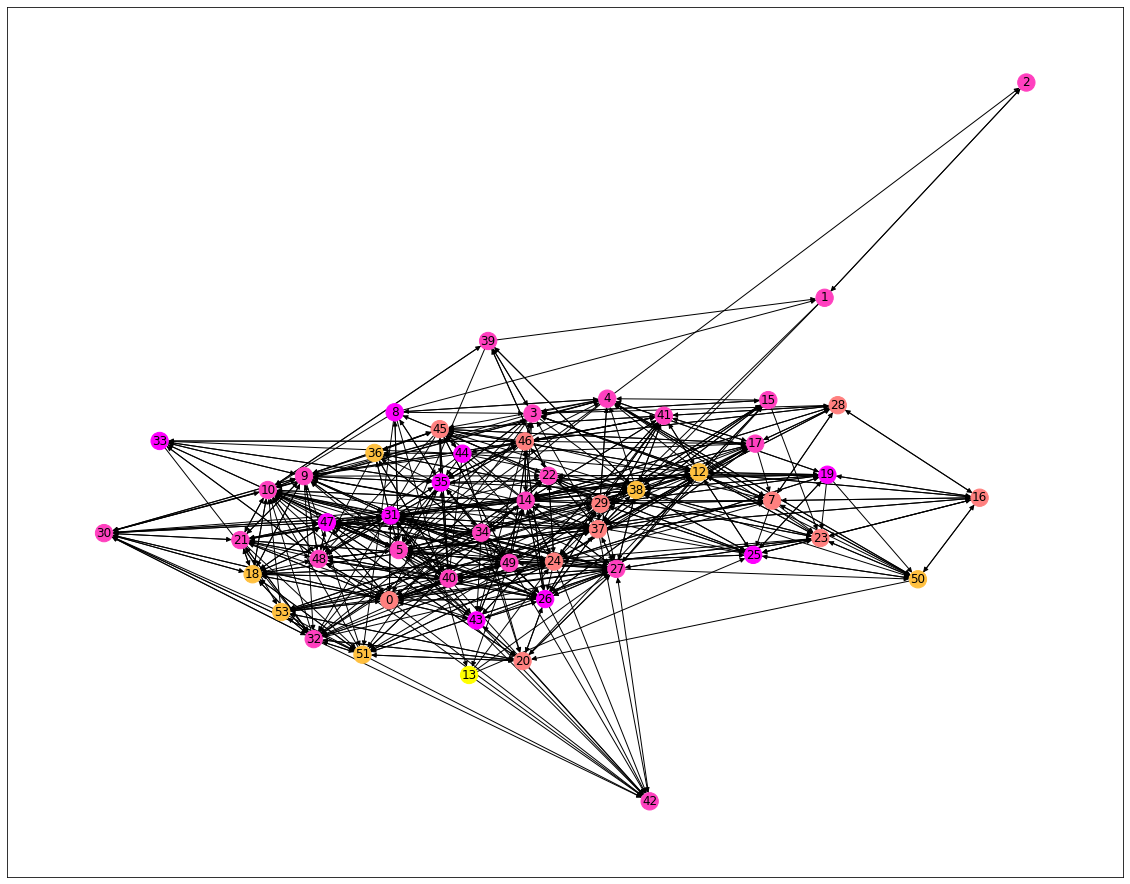

In [0]:
#ハブ度合いの可視化としては悪くない気がするけどどうなんだろうか？
plt.figure(figsize=(20, 16))
nx.draw_networkx(Graph, node_color=list(df2['cluster']), cmap=plt.cm.spring)
plt.show()